In [1]:
import os 
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-03 13:40:35.388732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 13:40:37.199074: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 13:40:37.203139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 13:40:38.637737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
PATH_HAZE="data/"

In [9]:
PATH=PATH_HAZE

In [10]:
BATCH_SIZE=4
image_shape=(256,256,3)

# LOading Data into tf.data

In [11]:

def load_image(image_path):
    '''Load and preprocess the image'''
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = (img / 127.5) - 1.0
    
    return img

def load_paired_data(real_image_path, fake_image_path):
    real_image = load_image(real_image_path)
    fake_image = load_image(fake_image_path)
    
    return real_image, fake_image

In [12]:
def load_dataset(PATH, test_ds = False):
    haze_images_paths = os.listdir(PATH + 'input')
    haze_images_paths = [PATH + 'input/'+  item   for item in haze_images_paths]
    haze_images_paths.sort()
#     if len(haze_images_paths) >= 100:
#         haze_images_paths = haze_images_paths[:100]
    

    clear_images_paths = os.listdir(PATH + 'target')
    clear_images_paths = [PATH + 'target/'+  item   for item in clear_images_paths]
    clear_images_paths.sort()
#     if len(clear_images_paths) >=100:
#         clear_images_paths = clear_images_paths[:100]
    

    dataset = tf.data.Dataset.from_tensor_slices((haze_images_paths, clear_images_paths))
    dataset = dataset.map(load_paired_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    if test_ds == True:
        dataset = dataset.batch(1)
        return dataset
    
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [13]:
train_ds = load_dataset(PATH + 'train/')
print(len(train_ds))

225


2024-05-03 13:43:35.683427: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
moderate_test_ds = load_dataset(PATH + 'test_moderate/', test_ds=True)
thick_test_ds = load_dataset(PATH + 'test_thick/', test_ds=True)
thin_test_ds = load_dataset(PATH + 'test_thin/', test_ds=True)

In [15]:
print(len(moderate_test_ds))

45


# Visualizing the Data

In [16]:
def subplot(img1, img2, title1, title2):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    img1 = (img1[0] + 1) / 2.0
    img2 = (img2[0] + 1) / 2.0

    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(img2)
    axes[1].set_title(title2)
    axes[1].axis('off')
    plt.show()

(4, 256, 256, 3)


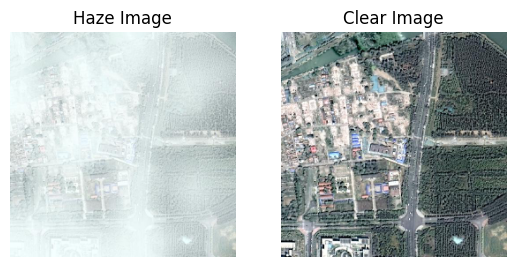

In [17]:
haze_image, clear_image  = next(iter(train_ds))
print(haze_image.shape)
subplot(haze_image, clear_image, 'Haze Image', 'Clear Image')

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Generator

In [20]:
class InceptionBlock(layers.Layer):
    def __init__(self, f, pooling=True):
        super(InceptionBlock, self).__init__()
        
        self.f = f
        self.pooling = pooling
        
        '''===PATH1==='''
        self.conva0 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_norma0 = layers.BatchNormalization()
        self.conva1 = layers.Conv2D(self.f, (3, 3), activation='relu', padding='same')
        self.batch_norma1 = layers.BatchNormalization()
        self.conva2 = layers.Conv2D(self.f, (1, 3), activation='relu', padding='same')
        self.batch_norma2 = layers.BatchNormalization()
        self.poola = layers.MaxPooling2D(pool_size=(2, 2))
        self.conva3 = layers.Conv2D(self.f, (3, 1), activation='relu', padding='same')
        self.batch_norma3 = layers.BatchNormalization()
        self.concat1 = layers.Concatenate(axis=-1)
        self.poola = layers.MaxPooling2D(pool_size=(2, 2))
        
        '''===PATH2==='''
        self.convb0 = layers.Conv2D(self.f, (1, 1), activation = 'relu', padding = 'same')
        self.batch_normb0 = layers.BatchNormalization()
        self.convb1 = layers.Conv2D(self.f, (1, 3), activation='relu', padding='same')
        self.batch_normb1 = layers.BatchNormalization()
        self.convb2 = layers.Conv2D(self.f, (3, 1), activation='relu', padding='same')
        self.batch_normb2 = layers.BatchNormalization()
        self.poolb = layers.MaxPooling2D(pool_size=(2, 2))
        self.concat2 = layers.Concatenate(axis=-1)
        
        '''===PATH3==='''
        self.ppoolc = layers.MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding='same')
        self.convc0 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_normc0 = layers.BatchNormalization()
        self.poolc = layers.MaxPooling2D(pool_size=(2, 2))
        
        '''===PATH4==='''
        self.convd1 = layers.Conv2D(self.f, (1, 1), activation='relu', padding='same')
        self.batch_normd1 = layers.BatchNormalization()
        self.poold = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.concat = layers.Concatenate(axis=-1)
    
    def call(self, inputs, training=False):
        conva = self.conva0(inputs) #1x1
        conva = self.batch_norma0(conva, training=training)
        conva = self.conva1(conva)  #3x3
        conva = self.batch_norma1(conva, training=training)
        conva_con1 = self.conva2(conva) # 1x3
        conva_con1 = self.batch_norma2(conva_con1, training=training)
        conva_con2 = self.conva3(conva) # 3x1
        conva_con2 = self.batch_norma3(conva_con2, training=training)
        conva = self.concat1([conva_con1, conva_con2])
        if self.pooling:
            conva = self.poola(conva)
            
        convb = self.convb0(inputs) # 1x1
        convb = self.batch_normb0(convb, training=training)
        convb_con1 = self.convb1(convb) # 1x3
        convb_con1 = self.batch_normb1(convb_con1, training=training)
        convb_con2 = self.convb2(convb) # 3x1
        convb_con2 = self.batch_normb2(convb_con2, training=training)
        convb = self.concat([convb_con1, convb_con2])
        if self.pooling:
            convb = self.poolb(convb)
            
        convc = self.ppoolc(inputs)
        convc = self.convc0(convc)
        convc = self.batch_normc0(convc, training=training)
        if self.pooling:
            convc = self.poolc(convc)
            
        convd = self.convd1(inputs)
        convd = self.batch_normd1(convd, training=training)
        if self.pooling:
            convd = self.poold(convd)
            
        up = self.concat([conva, convb, convc, convd])
        return up

In [21]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.init = tf.keras.initializers.RandomNormal(stddev=0.02, seed=123)
        
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv9 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')
        self.conv10 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')

        self.i1 = InceptionBlock(128, False)
        self.i2 = InceptionBlock(128, True)
        self.i3 = InceptionBlock(128, True)
        self.i4 = InceptionBlock(128, True)

        self.up6 = layers.Concatenate(axis=-1)
        self.conv11 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
        self.conv12 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')

        self.up7 = layers.Concatenate(axis=-1)
        self.conv13 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv14 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')

        self.up8 = layers.Concatenate(axis=-1)
        self.conv15 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv16 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')

        self.up9 = layers.Concatenate(axis=-1)
        self.conv17 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv18 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')

        self.conv19 = layers.Conv2D(3, (1, 1), activation='tanh')
        
        self.convT1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')
        self.convT2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')
        self.convT3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
        self.convT4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
        
    def call(self, batch):
        conv1 = self.conv1(batch)
        conv1 = self.conv2(conv1)
        pool1 = self.pool1(conv1)

        conv2 = self.conv3(pool1)
        conv2 = self.conv4(conv2)
        pool2 = self.pool2(conv2)

        conv3 = self.conv5(pool2)
        conv3 = self.conv6(conv3)
        pool3 = self.pool3(conv3)
        
        conv4 = self.conv7(pool3)
        conv4 = self.conv8(conv4)
        pool4 = self.pool4(conv4)

        conv5 = self.conv9(pool4)
        conv5 = self.conv10(conv5)

        i1 = self.i1(batch)
        i2 = self.i2(i1)
        i3 = self.i3(i2)
        i4 = self.i4(i3)

        up6 = self.up6([self.convT1(conv5), conv4, i4])
        conv6 = self.conv11(up6)
        conv6 = self.conv12(conv6)

        up7 = self.up7([self.convT2(conv6), conv3, i3])
        conv7 = self.conv13(up7)
        conv7 = self.conv14(conv7)

        up8 = self.up8([self.convT3(conv7), conv2, i2])
        conv8 = self.conv15(up8)
        conv8 = self.conv16(conv8)

        up9 = self.up9([self.convT4(conv8), conv1, i1])
        conv9 = self.conv17(up9)
        conv9 = self.conv18(conv9)

        conv10 = self.conv19(conv9)
        return conv10
    
    
    def build_summary(self, input_shape=image_shape):
        inp = Input(shape = input_shape)
        return Model(inputs = [inp], outputs = self.call(inp))

In [28]:
generator = Generator()


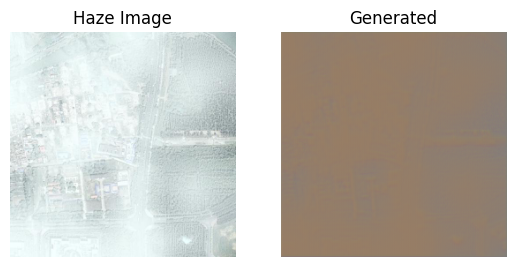

In [29]:
gen_output = generator(haze_image)

subplot(haze_image, gen_output, 'Haze Image', 'Generated')

In [30]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

# Discrimater

In [31]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.init = tf.keras.initializers.RandomNormal(stddev=0.02, seed=123)
        
        self.concat = layers.Concatenate()
        
        self.conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.leaky_relu1 = layers.LeakyReLU(alpha=0.2)
        
        self.conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU(alpha=0.2)
        
        self.conv3 = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU(alpha=0.2)
        
        self.conv4 = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=self.init)
        self.batch_norm4 = layers.BatchNormalization()
        self.leaky_relu4 = layers.LeakyReLU(alpha=0.2)
        
        self.conv5 = layers.Conv2D(512, (4, 4), padding='same', kernel_initializer=self.init)
        self.batch_norm5 = layers.BatchNormalization()
        self.leaky_relu5 = layers.LeakyReLU(alpha=0.2)
        
        self.conv6 = layers.Conv2D(1, (4, 4), padding='same', kernel_initializer=self.init)
        self.sigmoid = layers.Activation('sigmoid')
        
    def call(self, inp, tar):
        x = self.concat([inp, tar])
       
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu3(x)
        
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu4(x)
        
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.leaky_relu5(x)
        
        x = self.conv6(x)
        patch_out = self.sigmoid(x)
        
        return patch_out
    
    def build_summary(self, input_shape=(256,256,3)):
        inp = Input(shape = input_shape)
        tar = Input(shape = input_shape)
        return Model(inputs = [inp, tar], outputs = self.call(inp, tar))

In [32]:
discriminator = Discriminator()


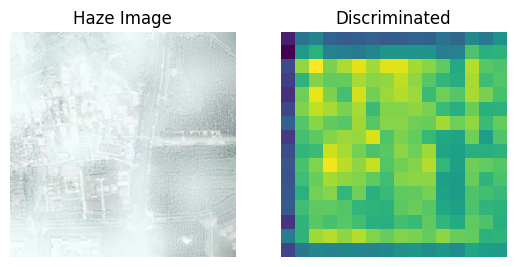

In [33]:
disc_output = discriminator(gen_output, haze_image)

subplot(haze_image, disc_output, 'Haze Image', 'Discriminated')

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [35]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# optimizers and LR scheduling

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Pix2PIx

In [37]:
class Pix2Pix(Model):
    def __init__(
        self,
        clear_generator,
        clear_discriminator,
    ):
        super(Pix2Pix, self).__init__()
        self.c_gen = clear_generator
        self.c_disc = clear_discriminator
        
    def compile(
        self,
        c_gen_optimizer,        
        c_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(Pix2Pix, self).compile()
        self.c_gen_optimizer = generator_optimizer
        self.c_disc_optimizer = discriminator_optimizer
        self.gen_loss_fn = generator_loss
        self.disc_loss_fn = discriminator_loss
        
    def train_step(self, batch_data):
        haze, clear = batch_data
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(haze, training=True)

            disc_real_output = discriminator(haze, clear, training=True)
            disc_generated_output = discriminator(haze, gen_output, training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, clear)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(
            gen_total_loss, generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(
            zip(generator_gradients, generator.trainable_variables)
        )
        discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, discriminator.trainable_variables)
        )
    
        return {
            'gen_total_loss': gen_total_loss,
            'gen_gan_loss' : gen_gan_loss,
            'gen_l1_loss' : gen_l1_loss,
            'disc_loss' : disc_loss   
        }
    
    

In [38]:
inp_img, tar_img = next(iter(moderate_test_ds))
def save_images(gen, test_input, name, step):
    pred_by_gen = gen(test_input)
    
    test_input = (test_input[0]+ 1)/2.0    
    pred_by_gen = (pred_by_gen[0]+1)/2.0
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input, pred_by_gen]
    title = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    filename = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename)
    plt.close()

In [39]:
class ReportCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%5 == 0:
            save_images(generator, inp_img, 'CtoH', epoch)

In [40]:
from tensorflow.keras.callbacks import CSVLogger

callbacks = [
    CSVLogger('training_res.csv'),
    ReportCallback()
]

# Training

In [41]:
pix2pix_gan = Pix2Pix(generator, discriminator)

pix2pix_gan.compile(c_gen_optimizer=generator_optimizer,
                  c_disc_optimizer=discriminator_optimizer,
                  gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss)

In [42]:
%%time
hist = pix2pix_gan.fit(train_ds, epochs=125,batch_size = BATCH_SIZE, callbacks=callbacks,verbose=1)

Epoch 1/125


2024-05-03 13:52:45.526946: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1962934272 exceeds 10% of free system memory.
2024-05-03 13:52:45.573159: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1962934272 exceeds 10% of free system memory.
2024-05-03 13:53:01.182652: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1610612736 exceeds 10% of free system memory.


  1/225 [..............................] - ETA: 2:41:18 - gen_total_loss: 62.9609 - gen_gan_loss: 1.1350 - gen_l1_loss: 0.6183 - disc_loss: 1.7039

2024-05-03 13:53:15.749670: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1962934272 exceeds 10% of free system memory.
2024-05-03 13:53:15.750822: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1962934272 exceeds 10% of free system memory.


225/225 [==============================] - 5045s 22s/step - gen_total_loss: 17.4642 - gen_gan_loss: 0.9335 - gen_l1_loss: 0.1653 - disc_loss: 1.3550
Epoch 2/125
225/225 [==============================] - 4935s 22s/step - gen_total_loss: 12.8633 - gen_gan_loss: 0.8827 - gen_l1_loss: 0.1198 - disc_loss: 1.3185
Epoch 3/125
134/225 [================>.............] - ETA: 33:21 - gen_total_loss: 11.4417 - gen_gan_loss: 0.8107 - gen_l1_loss: 0.1063 - disc_loss: 1.3481

# Saving and Loading Generator

In [ ]:
generator.save('generator_model')

In [ ]:
loaded_generator = tf.keras.models.load_model('generator_model')

# Evaluation 

In [ ]:
ssim_list = []
psnr_list = []

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def ssim_evaluation(img1, img2):
    ssim_value = ssim(img1, img2, channel_axis=2, data_range=img2.max() - img2.min())
    ssim_list.append(ssim_value)
    
def psnr_evaluation(img1, img2):
    psnr_value = psnr(img1,img2)
    psnr_list.append(psnr_value)

In [ ]:
def evaluate_model(model, inp, tar, sno):
    pred = model(inp, training=True)
    plt.figure(figsize=(15, 15))
    
    inp = inp[0].numpy()
    inp = (inp + 1)/2.0
    tar = tar[0].numpy()
    tar = (tar + 1)/2.0
    pred = pred[0].numpy()
    pred = (pred + 1)/2.0
    
    ## ssim
    ssim_curr = ssim_evaluation(tar, pred)
    
    ## psnr
    psnr_curr = psnr_evaluation(tar, pred)
    
    display_list = [inp, tar, pred]
    title = ['Haze Image', 'Ground Truth', 'Predicted Image']
   
    if sno<=5:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
    plt.close()
    

In [ ]:
import pandas as pd
skeleton = {
        'SSIM': [],
        'PSNR': []
}

In [ ]:
import statistics

def evaluate_test(test_ds, name):
    for i, (inp, tar) in test_ds.take(len(test_ds)).enumerate():
        evaluate_model(loaded_generator, inp, tar, i)
        
    ssim_mean = statistics.mean(ssim_list)
    psnr_mean = statistics.mean(psnr_list)
    
    print('Dataset-{}'.format(name))
    print(ssim_mean)
    print(psnr_mean)
    
    
    skeleton['SSIM'].append(ssim_mean)
    skeleton['PSNR'].append(psnr_mean)
        
    ssim_list.clear()
    psnr_list.clear()
    

In [ ]:
evaluate_test(moderate_test_ds, 'Moderate')
evaluate_test(thick_test_ds, 'Thick')
evaluate_test(thin_test_ds, 'Thin')

In [ ]:
df_res = pd.DataFrame(skeleton, index = ["Mod", "Thick", "Thin"])
df_res